# Word2Vec using Gensim

In [2]:
# Import all required packages.
import pandas as pd
import sklearn.manifold
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import re
import random
from tqdm import tqdm
import itertools
from nltk.corpus import stopwords

# Get the stopwords from the NLTK toolkit
stopWords = stopwords.words('english')

In [3]:
# Defining all the functions
def read_files():
    
    # Read all the Game of Thrones books and combine them into single corpus.
    file = open("data/got1.txt")
    corpus1 = file.read()
    file = open("data/got2.txt")
    corpus2 = file.read()
    file = open("data/got3.txt")
    corpus3 = file.read()
    file = open("data/got4.txt")
    corpus4 = file.read()
    file = open("data/got5.txt")
    corpus5 = file.read()
    data = corpus1 + corpus2 + corpus3 + corpus4 + corpus5
    
    return data

def clean_data(sentence):
    
    # Clean the data from all punctuation and remove all the stopwords.
    sentence = re.sub(r'[^A-Za-z0-9\s.]',r'',str(sentence).lower())
    sentence = re.sub(r'\n',r' ',sentence)
    sentence = " ".join([word for word in sentence.split() if word not in stopWords])
    
    return sentence

def shuffle_corpus(sentences):
    shuffled = list(sentences)
    random.shuffle(shuffled)
    
    return shuffled

# Function to visualize the bag of words
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

# Preprocessing the data

In [4]:
# Reading all the data.
data = read_files()

In [5]:
# Cleansing the big corpus and converting into DataFrame
data = data.splitlines()
data = list(filter(None, data))
data = pd.DataFrame(data)

In [23]:
# Do further cleaning and convert each sentences into tokens
data[0] = data[0].map(lambda x: clean_data(x))
tmp_corpus = data[0].map(lambda x: x.split('.'))

corpus = []
for i in tqdm(range(len(tmp_corpus))):
    for line in tmp_corpus[i]:
        words = [x for x in line.split()]
        corpus.append(words)

100%|██████████| 44758/44758 [00:01<00:00, 34786.57it/s]


In [25]:
print(corpus[0]) # Example of how each list in corpus looks like

['edition', 'contains', 'complete', 'text', 'original', 'hardcover', 'edition']


In [26]:
num_of_sentences = len(corpus)
num_of_words = 0
for line in corpus:
    num_of_words += len(line)

print('Num of sentences - %s'%(num_of_sentences))
print('Num of words - %s'%(num_of_words))

# To detect the common phrases and combine them into a single word
phrases = Phrases(sentences=corpus,min_count=25,threshold=50)
bigram = Phraser(phrases)

for index,sentence in enumerate(corpus):
    corpus[index] = bigram[sentence]

Num of sentences - 193648
Num of words - 949248


# Training the model

In [15]:
# Define the required parameters
size = 100
window_size = 2 # sentences weren't too long
epochs = 100
min_count = 2
workers = 4

model = Word2Vec(corpus, sg=1, window=window_size, size=size, min_count=min_count, workers=workers, iter=epochs, sample=0.01)

model.build_vocab(sentences=shuffle_corpus(corpus), update=True)

# Training the model
for i in tqdm(range(5)):
    model.train(sentences=shuffle_corpus(corpus), epochs=50, total_examples=model.corpus_count)

100%|██████████| 5/5 [04:19<00:00, 51.92s/it]


In [16]:
# Save the model for future use
model.save('w2v_model')

model = Word2Vec.load('w2v_model')

In [23]:
model.wv.most_similar('stark')

[('robb', 0.6231080889701843),
 ('starks', 0.6160929203033447),
 ('tully', 0.5696443915367126),
 ('karstark', 0.5640894174575806),
 ('eddard_stark', 0.5551910400390625),
 ('brandon', 0.5334932804107666),
 ('snowbeard', 0.5298494696617126),
 ('eddards', 0.5221171379089355),
 ('seemly', 0.5211370587348938),
 ('absently', 0.516395628452301)]

In [22]:
model.wv.most_similar('sansa')

[('arya', 0.7092865705490112),
 ('catelyn', 0.6733347177505493),
 ('cersei', 0.6014370918273926),
 ('ned', 0.5980891585350037),
 ('brienne', 0.5764607787132263),
 ('jeyne', 0.5578261613845825),
 ('margaery', 0.541135847568512),
 ('bran', 0.5373830199241638),
 ('joffrey', 0.5345661640167236),
 ('hysterically', 0.5316594839096069)]

In [46]:
model.wv.most_similar('aerys')

[('robert_baratheon', 0.5344989895820618),
 ('targaryen', 0.5265671014785767),
 ('rhaegar', 0.5210635662078857),
 ('hereditary', 0.5177336931228638),
 ('robert', 0.5115056037902832),
 ('brightfire', 0.501571536064148),
 ('king', 0.5007723569869995),
 ('father', 0.4999861419200897),
 ('rhaggat', 0.49075156450271606),
 ('viserys', 0.4905039370059967)]

# Model Visualization

In [24]:
# Reduce the dimension to 2 to visualize the data
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = model.wv.vectors

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [27]:
# Create a dataframe with all the words and their coordinates
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
points.head(10)

,word,x,y
0,edition,-16.380972,-5.046299
1,complete,8.890281,7.291276
2,text,-16.032681,-4.921350
3,original,-16.187880,-4.846864
4,hardcover,-16.272902,-4.956688
5,one,17.689283,3.117356
6,word,16.582230,5.896861
7,omitted,4.357709,-4.452822
8,clash,-3.208493,17.022274
9,kings,20.330975,-0.700613


In [29]:
sns.set_context("poster")

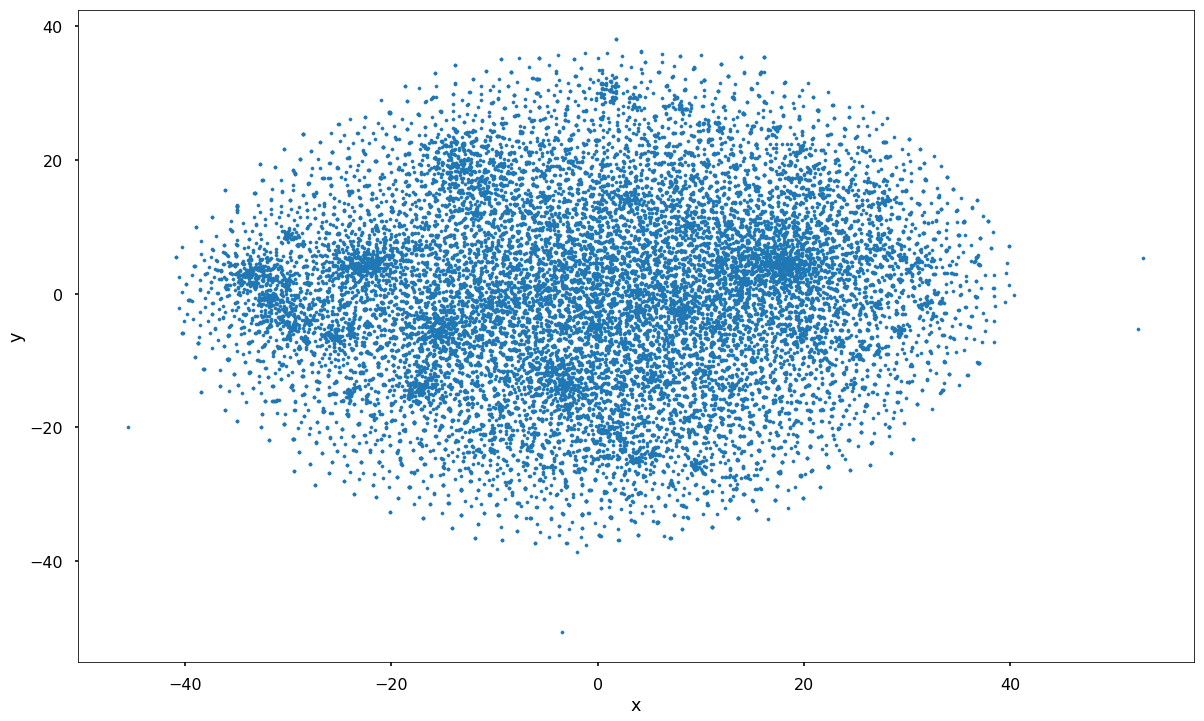

In [30]:
# Let's visualize the entire data
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

# Let's take a close look at the words

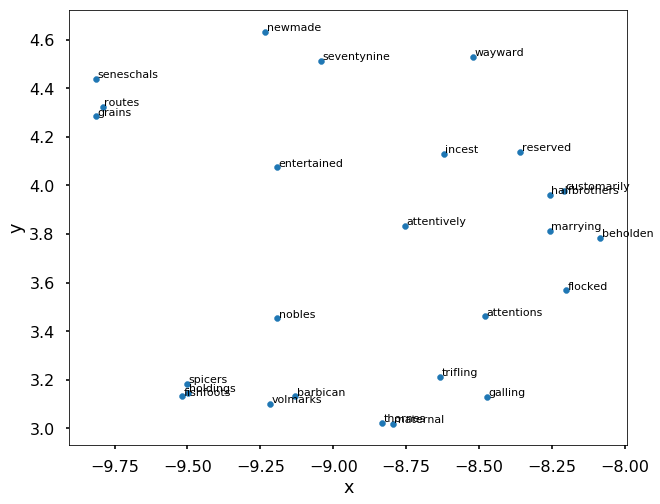

In [43]:
plot_region(x_bounds=(-10, -8), y_bounds=(3, 5))

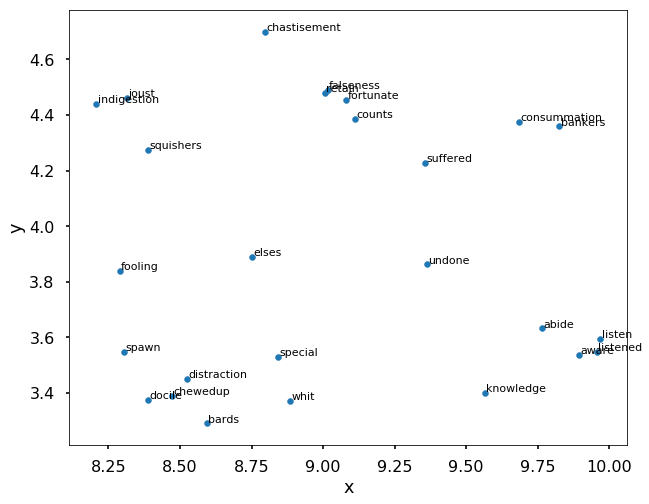

In [49]:
plot_region(x_bounds=(8, 10), y_bounds=(3, 5))